# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 15 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [1e5, 1e6, 1e7]

results = {}
best_val = -1
best_svm = None

pass
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs,
                              num_iters=1500, verbose=True)
        acc = np.mean(svm.predict(X_val_feats)==y_val)
        if (acc > best_val):
            best_val = acc
            best_svm = svm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 1500: loss 90.036325
iteration 100 / 1500: loss 88.432998
iteration 200 / 1500: loss 86.825521
iteration 300 / 1500: loss 85.270586
iteration 400 / 1500: loss 83.732816
iteration 500 / 1500: loss 82.248838
iteration 600 / 1500: loss 80.774894
iteration 700 / 1500: loss 79.337406
iteration 800 / 1500: loss 77.919875
iteration 900 / 1500: loss 76.539881
iteration 1000 / 1500: loss 75.178336
iteration 1100 / 1500: loss 73.851930
iteration 1200 / 1500: loss 72.544323
iteration 1300 / 1500: loss 71.265816
iteration 1400 / 1500: loss 70.012732
iteration 0 / 1500: loss 861.162437
iteration 100 / 1500: loss 706.446464
iteration 200 / 1500: loss 579.790254
iteration 300 / 1500: loss 476.081491
iteration 400 / 1500: loss 391.191271
iteration 500 / 1500: loss 321.706102
iteration 600 / 1500: loss 264.815991
iteration 700 / 1500: loss 218.243960
iteration 800 / 1500: loss 180.111612
iteration 900 / 1500: loss 148.898667
iteration 1000 / 1500: loss 123.352627
iteration 1100 / 1500: lo

In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy
print X_train_feats.shape

0.432
(49000, 160)


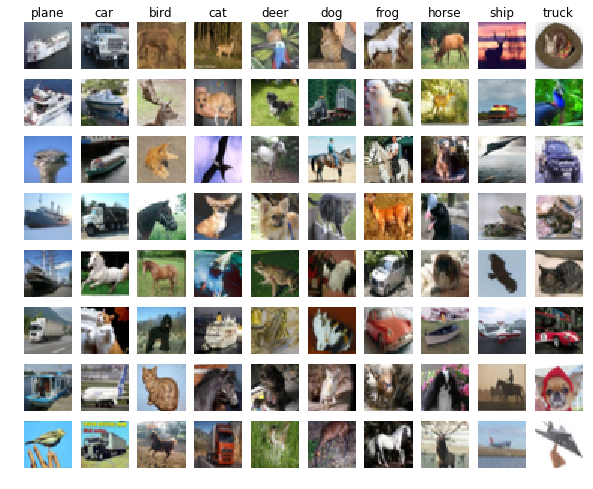

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
print X_train_feats.shape

(49000, 160)


In [9]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
num_classes = 10

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
best_net = None # store the best model into this 
best_acc = 0
regularizers = [0,1e-6, 1e-5, 1e-4,1e-2]
learning_rates = [1e-4, 1e-3,1e-2]
hidden_sizes = [200, 500, 1000, 2000]
dropouts = [0.5, 1.0]
results = {}

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
"""
cov_train = np.dot(X_train.T,X_train) / X_train.shape[0]
cov_val = np.dot(X_val.T, X_val) / X_val.shape[0]
U_train,S_train,V_train = np.linalg.svd(cov_train)
U_val, S_val, V_val = np.linalg.svd(cov_val)
X_train_rot = np.dot(X_train,U_train[:,:100])
X_val_rot = np.dot(X_val, U_val[:,:100])
"""

for rg in regularizers:
    for lr in learning_rates:
        for hs in hidden_sizes:
            for dp in dropouts:
                net = TwoLayerNet(X_train_feats.shape[1], hs, num_classes)
                # Train the network
                print
                print (rg, lr, hs)
                stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=2000, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=rg, dropout=dp, verbose=True)
                train_acc = (net.predict(X_train_feats) == y_train).mean()
                val_acc = (net.predict(X_val_feats) == y_val).mean()
                results[(lr,rg,hs)] = (train_acc,val_acc)
                if(val_acc > best_acc):
                    best_acc = val_acc
                    best_net = net
                
# Print out results.
for lr, reg, hs in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, hs)]
    print 'lr %e reg %e hidden %hs train accuracy: %f val accuracy: %f' % (
                lr, reg, hs, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_acc

################################################################################
#                              END OF YOUR CODE                                #
################################################################################


(0, 0.0001, 200)
iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 2.302583
iteration 200 / 2000: loss 2.302583
iteration 300 / 2000: loss 2.302584
iteration 400 / 2000: loss 2.302589
iteration 500 / 2000: loss 2.302586
iteration 600 / 2000: loss 2.302585
iteration 700 / 2000: loss 2.302596
iteration 800 / 2000: loss 2.302596
iteration 900 / 2000: loss 2.302583
iteration 1000 / 2000: loss 2.302584
iteration 1100 / 2000: loss 2.302581
iteration 1200 / 2000: loss 2.302591
iteration 1300 / 2000: loss 2.302589
iteration 1400 / 2000: loss 2.302584
iteration 1500 / 2000: loss 2.302575
iteration 1600 / 2000: loss 2.302580
iteration 1700 / 2000: loss 2.302583
iteration 1800 / 2000: loss 2.302577
iteration 1900 / 2000: loss 2.302574

(0, 0.0001, 200)
iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 2.302584
iteration 200 / 2000: loss 2.302588
iteration 300 / 2000: loss 2.302590
iteration 400 / 2000: loss 2.302582
iteration 500 / 2000: loss 2.302588
iteration 600 / 2000: 

iteration 0 / 4000: loss 2.302585
iteration 100 / 4000: loss 1.533303
iteration 200 / 4000: loss 1.415499
iteration 300 / 4000: loss 1.274806
iteration 400 / 4000: loss 1.381414
iteration 500 / 4000: loss 1.242741
iteration 600 / 4000: loss 1.119346
iteration 700 / 4000: loss 1.117806
iteration 800 / 4000: loss 1.056256
iteration 900 / 4000: loss 1.038134
iteration 1000 / 4000: loss 1.043822
iteration 1100 / 4000: loss 0.876333
iteration 1200 / 4000: loss 1.000612
iteration 1300 / 4000: loss 0.960128
iteration 1400 / 4000: loss 0.927886
iteration 1500 / 4000: loss 0.938615
iteration 1600 / 4000: loss 0.844662
iteration 1700 / 4000: loss 0.862553
iteration 1800 / 4000: loss 0.893968
iteration 1900 / 4000: loss 0.776084
iteration 2000 / 4000: loss 0.655796
iteration 2100 / 4000: loss 0.743060
iteration 2200 / 4000: loss 0.634560
iteration 2300 / 4000: loss 0.680575
iteration 2400 / 4000: loss 0.638507
iteration 2500 / 4000: loss 0.706823
iteration 2600 / 4000: loss 0.596220
iteration 270

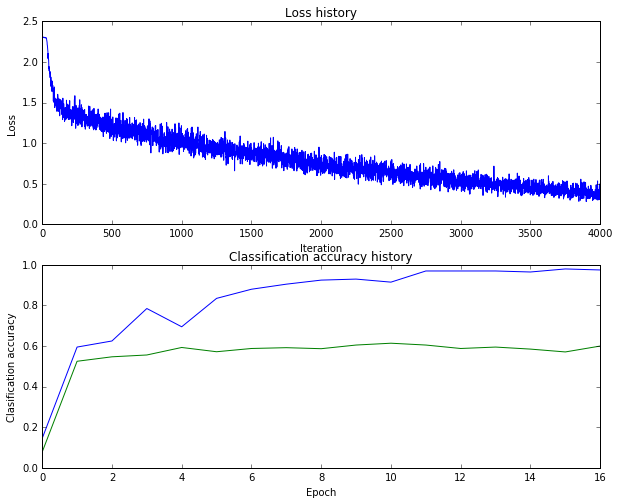

0.57


In [18]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.
# Plot the loss function and train / validation accuracies
# Train the network
net = TwoLayerNet(X_train_feats.shape[1], 1000, num_classes)

stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=4000, batch_size=200,
                learning_rate=5e-1, learning_rate_decay=0.95,
                reg=0.0, dropout=1.0, verbose=True)

plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()



test_acc = (net.predict(X_test_feats) == y_test).mean()
print test_acc

# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!

In [ ]:
def aggregate_data_in_range(data_list, report_start_date, report_end_date):
    aggregated_map = collections.defaultdict(dict)
    line_no = 0
    ecpa_goal = -1
    for line in data_list:
        if line['start_date'] >= report_start_date and line['start_date'] < report_end_date:
            # hide some verticals
            line_no += 1
            agg_list = aggregated_map[line['campaign_id']]
            
            try:
                float(line['ecpa_goal'])
                line['ecpa_goal'] = float(line['ecpa_goal'])
            except ValueError:
                line['ecpa_goal'] = -1
                
            ecpa_goal = max(ecpa_goal, line['ecpa_goal'])
            # SUM(impr)
            agg_list[support_metrics.IMPR] += long(line['impr'])
            # SUM(click)
            agg_list[support_metrics.CLICK] += long(line['click'])
            # SUM(pcconv)
            agg_list[support_metrics.PCCONV] += long(line['click_conv'])
            # SUM(spend)
            agg_list[support_metrics.SPEND] += float(line['spend'])
            # SUM(pclicks) but store to PCTR_ACCU first
            agg_list[support_metrics.PCTR_ACCU] += float(line['pclicks'])
            # SUM(pcconv) but store to PCVR_ACCU first
            agg_list[support_metrics.PCVR_ACCU] += float(line['pconvs'])
            #print ','.join([line['bucket_name'], line['demand_type'], line['vertical'], ' in processing '] + [str(i) for i in agg_list])
    print 'Processed data lines %d.' % line_no
    
    if agg_list[support_metrics.IMPR] > 0:
        # SUM(ctr)
        agg_list[support_metrics.CTR] = 1.0 * agg_list[support_metrics.CLICK] / agg_list[support_metrics.IMPR]
        # SUM(yield) yield = pcconv / impr
        agg_list[support_metrics.YIELD] = 1.0 * agg_list[support_metrics.PCCONV] / agg_list[support_metrics.IMPR]
        # SUM(cpm) cpm = spend/impr*1000
        agg_list[support_metrics.CPM] = 1000.0 * agg_list[support_metrics.SPEND] / agg_list[support_metrics.IMPR]
        # SUM(ctr err) ctr_err = SQRT(ctr*(1-ctr)/impr)*2
        agg_list[support_metrics.CTR_ERR] = math.sqrt(agg_list[support_metrics.CTR] * (1 - agg_list[support_metrics.CTR]) / agg_list[support_metrics.IMPR]) * 2

    if agg_list[support_metrics.CLICK] > 0:
        # SUM(cvr) cvr = pcconv / click
        agg_list[support_metrics.CVR] = 1.0 * agg_list[support_metrics.PCCONV] / agg_list[support_metrics.CLICK]
        # SUM(cvr err) cvr_err = SQRT(cvr* (1-cvr)/clicks)*2
        agg_list[support_metrics.CVR_ERR] = math.sqrt(agg_list[support_metrics.CVR] * (1 - agg_list[support_metrics.CVR]) / agg_list[support_metrics.CLICK]) * 2
        # SUM(cpc) cpc = spend / click
        agg_list[support_metrics.CPC] = 1.0 * agg_list[support_metrics.SPEND] / agg_list[support_metrics.CLICK]

    if agg_list[support_metrics.PCCONV] > 0:
        # SUM(cpi) cpi = spend / pcconv
        agg_list[support_metrics.CPI] = 1.0 * agg_list[support_metrics.SPEND] / agg_list[support_metrics.PCCONV]

        # SUM(pctr accu) which is click / pclick 
    if agg_list[support_metrics.PCTR_ACCU] > 0:
        agg_list[support_metrics.PCTR_ACCU] = 1.0 * agg_list[support_metrics.CLICK] / agg_list[support_metrics.PCTR_ACCU]

    # SUM(pcvr accu) which is pc_conv / p_pcConv
    if agg_list[support_metrics.PCVR_ACCU] > 0:
        agg_list[support_metrics.PCVR_ACCU] = 1.0 * agg_list[support_metrics.PCCONV] / agg_list[support_metrics.PCVR_ACCU]

    #print ','.join([bucket_group_name, demand_type, vertical, ' final '] + [str(i) for i in agg_list])
                
    return aggregated_map

def load_data(filename):
    data_file = open(filename)
    data_list = []
    latest_process_date=''
    for line in data_file:
        data_row = line.split('\x01')
        if data_row[1] != 'appInstall' or data_row[2] in vertical_blacklist:
            continue
        record = {}
        record['start_date'] = data_row[0]
        record['demand_type'] = data_row[1]
        record['vertical'] = data_row[2] if data_row[2] != '\\N' else 'OTHER'
        if record['vertical'] in vertical_mappi:
            record['vertical'] = vertical_mappi[record['vertical']]
        record['filter'] = data_row[4]
        record['bucket_name'] = data_row[5]
        record['cmpgn_id'] = data_row[7]
        record['advertiser_id'] = data_row[8]
        record['page_section'] = data_row[9]
        record['impr'] = data_row[10]
        record['click'] = data_row[11]
        record['click_conv'] = data_row[12]
        record['spend'] = data_row[15]
        record['pclicks'] = data_row[16]
        record['pconvs'] = data_row[17] if data_row[17] != '\\N' else 0.0
        data_list.append(record)
    data_file.close()
    print "Load data lines " + str(len(data_list))
    return data_list

if __name__ == '__main__':

    data_list = load_data(sys.argv[1])
    html_output_file = sys.argv[2]
    
    today = datetime.strptime(sys.argv[3], '%Y%m%d%H%M')
    tomorrow = (today + timedelta(days=1)).strftime('%Y%m%d%H%M')
    day_minus1 = (today + timedelta(days=-1)).strftime('%Y%m%d%H%M')
    day_minus2 = (today + timedelta(days=-2)).strftime('%Y%m%d%H%M')
    day_minus6 = (today + timedelta(days=-6)).strftime('%Y%m%d%H%M')
    day_minus7 = (today + timedelta(days=-7)).strftime('%Y%m%d%H%M')
    day_minus8 = (today + timedelta(days=-8)).strftime('%Y%m%d%H%M')
    today = today.strftime('%Y%m%d%H%M')

    aggregated_map_weekly_today = aggregate_data_in_range(data_list, bucket_config, day_minus6, tomorrow)
    aggregated_map_weekly_minus1 = aggregate_data_in_range(data_list, bucket_config, day_minus7, today)
    aggregated_map_weekly_minus2 = aggregate_data_in_range(data_list, bucket_config, day_minus8, day_minus1)

    aggregated_map_daily_today = aggregate_data_in_range(data_list, bucket_config, today, tomorrow)
    aggregated_map_daily_minus1 = aggregate_data_in_range(data_list, bucket_config, day_minus1, today)
    aggregated_map_daily_minus2 = aggregate_data_in_range(data_list, bucket_config, day_minus2, day_minus1)

    for k, v in enumerate(aggregated_map_weekly_today):
        print k, v
    
    #saved_html = '\n'.join([header_html, compare_table_html] + aggregation_table_html)
    #save_html(saved_html, html_output_file)
    #print saved_html 